In [1]:
## 設定
verbose = False

### 言語の割合の均等化
balanced = True

### LDA 用

## トピック数
n_topics = 15 # 30は多過ぎる？

## doc, term の設定
doc_type      = 'form'
doc_attr      = 'sound'
max_doc_size  = 12
##
term_size = 'character'
term_type = '1gram'
## skippy n-gram の結合範囲
max_distance_val = round(max_doc_size * 0.8)
print(f"max_distance_val: {max_distance_val}")

## ngram を包括的にするかどうか
ngram_is_inclusive = True

### DTM 構築

## term の最低頻度
term_min_freq = 2

## 高頻度 term の濫用指標: 大きくし過ぎないように．0.05 は十分に大きい
term_abuse_threshold = 0.05

max_distance_val: 10


In [2]:
import sys, os, random, re, glob
import pandas as pd
import pprint as pp
from functools import reduce

In [3]:
## load data to process
from pathlib import Path
import pprint as pp

wd = Path(".")
##
dirs = [ x for x in wd.iterdir() if x.is_dir() and not x.match(r"plot*") ]
if verbose:
    print(f"The following {len(dirs)} directories are potential targets:")
    pp.pprint(dirs)

## list up files in target directory 
wd = Path(".")
target_dir = "data-words" # can be changed
target_files = sorted(list(wd.glob(f"{target_dir}/*.csv")))
#
print(f"\n{target_dir} contains {len(target_files)} files to process")
pp.pprint(target_files)


data-words contains 10 files to process
[PosixPath('data-words/base-sound-English-r6e-originals.csv'),
 PosixPath('data-words/base-sound-French-r0-sample900.csv'),
 PosixPath('data-words/base-sound-German-r1a-original.csv'),
 PosixPath('data-words/base-spell-English-r6e-originals.csv'),
 PosixPath('data-words/base-spell-Esperanto-r0-orginal.csv'),
 PosixPath('data-words/base-spell-French-r0-originals.csv'),
 PosixPath('data-words/base-spell-German-r1a-originals.csv'),
 PosixPath('data-words/base-spell-Icelandic-r0-original.csv'),
 PosixPath('data-words/base-spell-Russian-r0-originals.csv'),
 PosixPath('data-words/base-spell-Swahili-r0-orginal.csv')]


In [4]:
import pandas as pd

## データ型の辞書
types = "spell sound freq".split(" ")
type_setting = { t : 0 for t in types }
print(type_setting)

## 言語名の辞書
langs = "english esperanto french german icelandic russian swahili".split(" ")
#langs = "english esperanto french german russian swahili".split(" ")
#langs = "english esperanto french german icelandic swahili".split(" ")
lang_setting = { lang : 0 for lang in langs }
print(lang_setting)

## 辞書と統合
settings = { 'form': None, **type_setting, **lang_setting }
print(settings)

{'spell': 0, 'sound': 0, 'freq': 0}
{'english': 0, 'esperanto': 0, 'french': 0, 'german': 0, 'icelandic': 0, 'russian': 0, 'swahili': 0}
{'form': None, 'spell': 0, 'sound': 0, 'freq': 0, 'english': 0, 'esperanto': 0, 'french': 0, 'german': 0, 'icelandic': 0, 'russian': 0, 'swahili': 0}


In [5]:
vars = list(settings.keys())
print(f"targe var names: {vars}")

d_parts = [ ]
for lang in langs:
    local_settings = settings.copy()
    print(f"processing: {lang}")
    try:
        for f in [ f for f in target_files if lang.capitalize() in str(f) ]:
            print(f"reading: {f}")
            # 言語名の指定
            local_settings[lang] = 1
            # 型名の指定
            for type in vars:
                if type in str(f):
                    local_settings[type] = 1
            #
            d = pd.read_csv(f, encoding='utf-8', sep = ",", on_bad_lines = 'skip') # Crucially, ...= skip
            df = pd.DataFrame(d, columns = vars)
            for var in [ var for var in (types + langs) if var != 'freq' ]:
                df[var] = local_settings[var]
            d_parts.append(df)
    except IndexError:
        pass
#
if verbose:
    d_parts

targe var names: ['form', 'spell', 'sound', 'freq', 'english', 'esperanto', 'french', 'german', 'icelandic', 'russian', 'swahili']
processing: english
reading: data-words/base-sound-English-r6e-originals.csv
reading: data-words/base-spell-English-r6e-originals.csv
processing: esperanto
reading: data-words/base-spell-Esperanto-r0-orginal.csv
processing: french
reading: data-words/base-sound-French-r0-sample900.csv
reading: data-words/base-spell-French-r0-originals.csv
processing: german
reading: data-words/base-sound-German-r1a-original.csv
reading: data-words/base-spell-German-r1a-originals.csv
processing: icelandic
reading: data-words/base-spell-Icelandic-r0-original.csv
processing: russian
reading: data-words/base-spell-Russian-r0-originals.csv
processing: swahili
reading: data-words/base-spell-Swahili-r0-orginal.csv


In [6]:
## データ統合

raw_df = pd.concat(d_parts)
raw_df

form  spell  sound freq  english  esperanto  french  german  \
0    æbəhəlimə      0      1    1        1          0       0       0   
1       ædmaɪə      0      1    1        1          0       0       0   
2      ædmɪʃən      0      1    1        1          0       0       0   
3    ædvæntɪdʒ      0      1    1        1          0       0       0   
4       ædvaɪs      0      1    1        1          0       0       0   
..         ...    ...    ...  ...      ...        ...     ...     ...   
703      zaidi      1      0    1        0          0       0       0   
704      ziara      1      0    1        0          0       0       0   
705       zima      1      0    1        0          0       0       0   
706       ziwa      1      0    1        0          0       0       0   
707      zoezi      1      0    1        0          0       0       0   

     icelandic  russian  swahili  
0            0        0        0  
1            0        0        0  
2            0        0        0  
3            0        0        0  
4            0        0        0  
..         ...      ...      ...  
703          0        0        1  
704          0        0        1  
705          0        0        1  
706          0        0        1  
707          0        0        1  

[15223 rows x 11 columns]

In [7]:
## 文字数の列を追加

raw_df['size'] = [ len(x) for x in raw_df[doc_type] ]
raw_df

form  spell  sound freq  english  esperanto  french  german  \
0    æbəhəlimə      0      1    1        1          0       0       0   
1       ædmaɪə      0      1    1        1          0       0       0   
2      ædmɪʃən      0      1    1        1          0       0       0   
3    ædvæntɪdʒ      0      1    1        1          0       0       0   
4       ædvaɪs      0      1    1        1          0       0       0   
..         ...    ...    ...  ...      ...        ...     ...     ...   
703      zaidi      1      0    1        0          0       0       0   
704      ziara      1      0    1        0          0       0       0   
705       zima      1      0    1        0          0       0       0   
706       ziwa      1      0    1        0          0       0       0   
707      zoezi      1      0    1        0          0       0       0   

     icelandic  russian  swahili  size  
0            0        0        0     9  
1            0        0        0     6  
2            0        0        0     7  
3            0        0        0     9  
4            0        0        0     6  
..         ...      ...      ...   ...  
703          0        0        1     5  
704          0        0        1     5  
705          0        0        1     4  
706          0        0        1     4  
707          0        0        1     5  

[15223 rows x 12 columns]

In [8]:
## 言語名= language の列を追加

check = False
language_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    for j, lang in enumerate(langs):
        if check:
            print(f"{i}: {lang}")
        if row[lang] == 1:
            language_vals.append(lang)
if verbose:
    print(language_vals)
    len(language_vals)
#
raw_df['language'] = language_vals
raw_df

form  spell  sound freq  english  esperanto  french  german  \
0    æbəhəlimə      0      1    1        1          0       0       0   
1       ædmaɪə      0      1    1        1          0       0       0   
2      ædmɪʃən      0      1    1        1          0       0       0   
3    ædvæntɪdʒ      0      1    1        1          0       0       0   
4       ædvaɪs      0      1    1        1          0       0       0   
..         ...    ...    ...  ...      ...        ...     ...     ...   
703      zaidi      1      0    1        0          0       0       0   
704      ziara      1      0    1        0          0       0       0   
705       zima      1      0    1        0          0       0       0   
706       ziwa      1      0    1        0          0       0       0   
707      zoezi      1      0    1        0          0       0       0   

     icelandic  russian  swahili  size language  
0            0        0        0     9  english  
1            0        0        0     6  english  
2            0        0        0     7  english  
3            0        0        0     9  english  
4            0        0        0     6  english  
..         ...      ...      ...   ...      ...  
703          0        0        1     5  swahili  
704          0        0        1     5  swahili  
705          0        0        1     4  swahili  
706          0        0        1     4  swahili  
707          0        0        1     5  swahili  

[15223 rows x 13 columns]

In [9]:
## 言語の選別

select_languages = True

selected_langs = re.split(r",\s*", "english, french, german, russian, swahili")
print(f"selected languages: {selected_langs}")

if select_languages:
    df_new = [ ]
    for lang in selected_langs:
        df_new.append(raw_df[raw_df[lang] == 1])
    raw_df = pd.concat(df_new)
#
raw_df

selected languages: ['english', 'french', 'german', 'russian', 'swahili']


form  spell  sound freq  english  esperanto  french  german  \
0    æbəhəlimə      0      1    1        1          0       0       0   
1       ædmaɪə      0      1    1        1          0       0       0   
2      ædmɪʃən      0      1    1        1          0       0       0   
3    ædvæntɪdʒ      0      1    1        1          0       0       0   
4       ædvaɪs      0      1    1        1          0       0       0   
..         ...    ...    ...  ...      ...        ...     ...     ...   
703      zaidi      1      0    1        0          0       0       0   
704      ziara      1      0    1        0          0       0       0   
705       zima      1      0    1        0          0       0       0   
706       ziwa      1      0    1        0          0       0       0   
707      zoezi      1      0    1        0          0       0       0   

     icelandic  russian  swahili  size language  
0            0        0        0     9  english  
1            0        0        0     6  english  
2            0        0        0     7  english  
3            0        0        0     9  english  
4            0        0        0     6  english  
..         ...      ...      ...   ...      ...  
703          0        0        1     5  swahili  
704          0        0        1     5  swahili  
705          0        0        1     4  swahili  
706          0        0        1     4  swahili  
707          0        0        1     5  swahili  

[13673 rows x 13 columns]

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_40794/1088473461.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


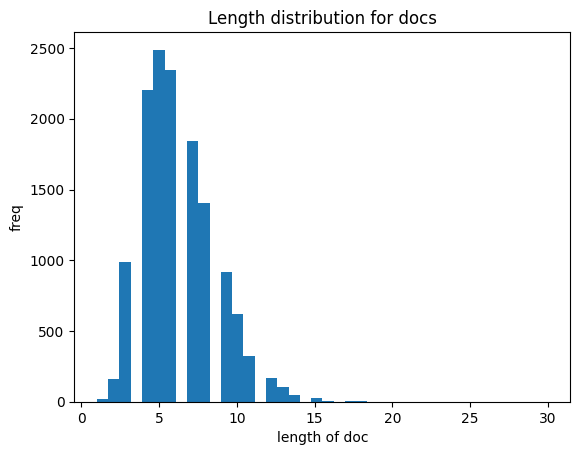

In [10]:
## 文字数の分布
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(raw_df['size'], bins = 40)
ax.set_xlabel('length of doc')
ax.set_ylabel('freq')
plt.title(f"Length distribution for docs")
fig.show()

In [11]:
## 長さで濾過

print(f"max doc size: {max_doc_size}")
original_size = len(raw_df)
raw_df = raw_df[raw_df['size'] < max_doc_size]
filtered_size = len(raw_df)
print(f"{original_size - filtered_size} cases removed")

max doc size: 12
365 cases removed


In [12]:
## 結果の検査 1

for lang in langs:
    print(raw_df[lang].value_counts())

english
1    8249
0    5059
Name: count, dtype: int64
esperanto
0    13308
Name: count, dtype: int64
french
0    11492
1     1816
Name: count, dtype: int64
german
0    11743
1     1565
Name: count, dtype: int64
icelandic
0    13308
Name: count, dtype: int64
russian
0    12335
1      973
Name: count, dtype: int64
swahili
0    12603
1      705
Name: count, dtype: int64


In [13]:
## 結果の検査 2

for type in types:
    print(raw_df[type].value_counts())

spell
1    7588
0    5720
Name: count, dtype: int64
sound
1    11630
0     1678
Name: count, dtype: int64
freq
1                  12326
1                    966
1 не                   1
1 то время как         1
1 северу               1
1 него                 1
1 будет                1
1 образом              1
1 мышь                 1
Name: count, dtype: int64


In [14]:
## 統合: 割合補正を適用

eng_reduct_factor = 0.2
if balanced:
    eng_df = raw_df[raw_df['english'] == 1]
    non_eng_df = raw_df[raw_df['english'] == 0]
    eng_reduced_df = eng_df.sample(round(len(eng_df) * eng_reduct_factor))
    raw_df = pd.concat([eng_reduced_df, non_eng_df])
raw_df

form  spell  sound freq  english  esperanto  french  german  \
1875  icelandair      1      1  1.0        1          0       0       0   
2805        tɛnd      0      1    1        1          0       0       0   
2250      pɔɪnts      0      1    1        1          0       0       0   
91    aɪdɛntəfaɪ      0      1    1        1          0       0       0   
3482      slight      1      1  1.0        1          0       0       0   
...          ...    ...    ...  ...      ...        ...     ...     ...   
703        zaidi      1      0    1        0          0       0       0   
704        ziara      1      0    1        0          0       0       0   
705         zima      1      0    1        0          0       0       0   
706         ziwa      1      0    1        0          0       0       0   
707        zoezi      1      0    1        0          0       0       0   

      icelandic  russian  swahili  size language  
1875          0        0        0    10  english  
2805          0        0        0     4  english  
2250          0        0        0     6  english  
91            0        0        0    10  english  
3482          0        0        0     6  english  
...         ...      ...      ...   ...      ...  
703           0        0        1     5  swahili  
704           0        0        1     5  swahili  
705           0        0        1     4  swahili  
706           0        0        1     4  swahili  
707           0        0        1     5  swahili  

[6709 rows x 13 columns]

In [15]:
## データの指定

raw_df = raw_df[raw_df[doc_attr] == 1]
print(f"doc_attr: {doc_attr}")
raw_df

doc_attr: sound


form  spell  sound freq  english  esperanto  french  german  \
1875  icelandair      1      1  1.0        1          0       0       0   
2805        tɛnd      0      1    1        1          0       0       0   
2250      pɔɪnts      0      1    1        1          0       0       0   
91    aɪdɛntəfaɪ      0      1    1        1          0       0       0   
3482      slight      1      1  1.0        1          0       0       0   
...          ...    ...    ...  ...      ...        ...     ...     ...   
787       singen      1      1    1        0          0       0       1   
788       sitzen      1      1    1        0          0       0       1   
789       sommer      1      1    1        0          0       0       1   
790       suchen      1      1    1        0          0       0       1   
791       suffix      1      1    1        0          0       0       1   

      icelandic  russian  swahili  size language  
1875          0        0        0    10  english  
2805          0        0        0     4  english  
2250          0        0        0     6  english  
91            0        0        0    10  english  
3482          0        0        0     6  english  
...         ...      ...      ...   ...      ...  
787           0        0        0     6   german  
788           0        0        0     6   german  
789           0        0        0     6   german  
790           0        0        0     6   german  
791           0        0        0     6   german  

[5031 rows x 13 columns]

In [16]:
## 結果の検査 3

for lang in langs:
    print(raw_df[lang].value_counts())

english
0    3381
1    1650
Name: count, dtype: int64
esperanto
0    5031
Name: count, dtype: int64
french
0    3215
1    1816
Name: count, dtype: int64
german
0    3466
1    1565
Name: count, dtype: int64
icelandic
0    5031
Name: count, dtype: int64
russian
0    5031
Name: count, dtype: int64
swahili
0    5031
Name: count, dtype: int64


# 解析

In [17]:
## 順序のランダマイズし，基本データを決定

import sklearn.utils
df = sklearn.utils.shuffle(raw_df)

In [18]:
## ngram の追加

import sys
sys.path.append('..')

import re
import ngrams
import importlib
importlib.reload(ngrams)
import ngrams_skippy

bases = df[doc_type]

## 1gram 列の追加
#sep = r""
#unigrams = [ list(filter(lambda x: len(x) > 0, y)) for y in [ re.split(sep, z) for z in bases ] ]
unigrams = ngrams.gen_unigrams(bases, sep = r"", check = False)
if verbose:
    random.sample(unigrams, 5)
#
df['1gram'] = unigrams
#df.loc[:,'1gram'] = unigrams
df

form  spell  sound freq  english  esperanto  french  german  \
3329      ənlɛs      0      1    1        1          0       0       0   
463       kampf      0      1    1        0          0       0       1   
287    toujours      1      1  1.0        0          0       1       0   
142       avant      1      1  1.0        0          0       1       0   
458         ich      1      1    1        0          0       0       1   
...         ...    ...    ...  ...      ...        ...     ...     ...   
1436      first      1      1  1.0        1          0       0       0   
1979      pawəɹ      0      1    1        1          0       0       0   
167    formular      1      1    1        0          0       0       1   
145   debʁidəʁɛ      0      1    1        0          0       1       0   
393     sammeln      1      1    1        0          0       0       1   

      icelandic  russian  swahili  size language                        1gram  
3329          0        0        0     5  english              [ə, n, l, ɛ, s]  
463           0        0        0     5   german              [k, a, m, p, f]  
287           0        0        0     8   french     [t, o, u, j, o, u, r, s]  
142           0        0        0     5   french              [a, v, a, n, t]  
458           0        0        0     3   german                    [i, c, h]  
...         ...      ...      ...   ...      ...                          ...  
1436          0        0        0     5  english              [f, i, r, s, t]  
1979          0        0        0     5  english              [p, a, w, ə, ɹ]  
167           0        0        0     8   german     [f, o, r, m, u, l, a, r]  
145           0        0        0     9   french  [d, e, b, ʁ, i, d, ə, ʁ, ɛ]  
393           0        0        0     7   german        [s, a, m, m, e, l, n]  

[5031 rows x 14 columns]

In [19]:
## 2gram列の追加

bigrams = ngrams.gen_bigrams(bases, sep = r"", check = False)

## 包括的 2gram の作成
if ngram_is_inclusive:
    bigrams = [ [*b, *u] for b, u in zip(bigrams, unigrams) ]

if verbose:
    print(random.sample(bigrams, 3))

In [20]:
df['2gram'] = bigrams
if verbose:
    df

In [21]:
## 3gram列の追加

trigrams = ngrams.gen_trigrams(bases, sep = r"", check = False)

## 包括的 3gram の作成
if ngram_is_inclusive:
    trigrams = [ [ *t, *b ] for t, b in  zip(trigrams, bigrams) ]

if verbose:
    print(random.sample(trigrams, 3))

In [22]:
df['3gram'] = trigrams
if verbose:
    df

In [23]:
## skippy 2grams の生成

import sys
sys.path.append("..") # library path に一つ上の階層を追加

import ngrams_skippy

skippy_2grams = [ ngrams_skippy.generate_skippy_bigrams(x,
                                                         missing_mark = '…',
                                                         max_distance = max_distance_val, check = False)
                  for x in df['1gram'] ]

## 包括的 skippy 2-grams の生成
if ngram_is_inclusive:
    for i, b2 in enumerate(skippy_2grams):
        b2.extend(unigrams[i])
#
if verbose:
    random.sample(skippy_2grams, 3)

In [24]:
## skippy 2gram 列の追加

df['skippy2gram'] = skippy_2grams
df

form  spell  sound freq  english  esperanto  french  german  \
3329      ənlɛs      0      1    1        1          0       0       0   
463       kampf      0      1    1        0          0       0       1   
287    toujours      1      1  1.0        0          0       1       0   
142       avant      1      1  1.0        0          0       1       0   
458         ich      1      1    1        0          0       0       1   
...         ...    ...    ...  ...      ...        ...     ...     ...   
1436      first      1      1  1.0        1          0       0       0   
1979      pawəɹ      0      1    1        1          0       0       0   
167    formular      1      1    1        0          0       0       1   
145   debʁidəʁɛ      0      1    1        0          0       1       0   
393     sammeln      1      1    1        0          0       0       1   

      icelandic  russian  swahili  size language                        1gram  \
3329          0        0        0     5  english              [ə, n, l, ɛ, s]   
463           0        0        0     5   german              [k, a, m, p, f]   
287           0        0        0     8   french     [t, o, u, j, o, u, r, s]   
142           0        0        0     5   french              [a, v, a, n, t]   
458           0        0        0     3   german                    [i, c, h]   
...         ...      ...      ...   ...      ...                          ...   
1436          0        0        0     5  english              [f, i, r, s, t]   
1979          0        0        0     5  english              [p, a, w, ə, ɹ]   
167           0        0        0     8   german     [f, o, r, m, u, l, a, r]   
145           0        0        0     9   french  [d, e, b, ʁ, i, d, ə, ʁ, ɛ]   
393           0        0        0     7   german        [s, a, m, m, e, l, n]   

                                                  2gram  \
3329                    [ən, nl, lɛ, ɛs, ə, n, l, ɛ, s]   
463                     [ka, am, mp, pf, k, a, m, p, f]   
287   [to, ou, uj, jo, ou, ur, rs, t, o, u, j, o, u,...   
142                     [av, va, an, nt, a, v, a, n, t]   
458                                   [ic, ch, i, c, h]   
...                                                 ...   
1436                    [fi, ir, rs, st, f, i, r, s, t]   
1979                    [pa, aw, wə, əɹ, p, a, w, ə, ɹ]   
167   [fo, or, rm, mu, ul, la, ar, f, o, r, m, u, l,...   
145   [de, eb, bʁ, ʁi, id, də, əʁ, ʁɛ, d, e, b, ʁ, i...   
393       [sa, am, mm, me, el, ln, s, a, m, m, e, l, n]   

                                                  3gram  \
3329     [ənl, nlɛ, lɛs, ən, nl, lɛ, ɛs, ə, n, l, ɛ, s]   
463      [kam, amp, mpf, ka, am, mp, pf, k, a, m, p, f]   
287   [tou, ouj, ujo, jou, our, urs, to, ou, uj, jo,...   
142      [ava, van, ant, av, va, an, nt, a, v, a, n, t]   
458                              [ich, ic, ch, i, c, h]   
...                                                 ...   
1436     [fir, irs, rst, fi, ir, rs, st, f, i, r, s, t]   
1979     [paw, awə, wəɹ, pa, aw, wə, əɹ, p, a, w, ə, ɹ]   
167   [for, orm, rmu, mul, ula, lar, fo, or, rm, mu,...   
145   [deb, ebʁ, bʁi, ʁid, idə, dəʁ, əʁɛ, de, eb, bʁ...   
393   [sam, amm, mme, mel, eln, sa, am, mm, me, el, ...   

                                            skippy2gram  
3329  [ən, ə…l, ə…ɛ, ə…s, nl, n…ɛ, n…s, lɛ, l…s, ɛs,...  
463   [ka, k…m, k…p, k…f, am, a…p, a…f, mp, m…f, pf,...  
287   [to, t…u, t…j, t…o, t…r, t…s, ou, o…j, o…o, o…...  
142   [av, a…a, a…n, a…t, va, v…n, v…t, an, nt, a, v...  
458                              [ic, i…h, ch, i, c, h]  
...                                                 ...  
1436  [fi, f…r, f…s, f…t, ir, i…s, i…t, rs, r…t, st,...  
1979  [pa, p…w, p…ə, p…ɹ, aw, a…ə, a…ɹ, wə, w…ɹ, əɹ,...  
167   [fo, f…r, f…m, f…u, f…l, f…a, or, o…m, o…u, o…...  
145   [de, d…b, d…ʁ, d…i, d…d, d…ə, d…ɛ, eb, e…ʁ, e…...  
393   [sa, s…m, s…e, s…l, s…n, am, a…m, a…e, a…l, a…...  

[5031 rows x 17 columns]

In [25]:
## skippy 3grams の生成

import sys
sys.path.append("..") # library path に一つ上の階層を追加

import ngrams_skippy

skippy_3grams = [ ngrams_skippy.generate_skippy_trigrams(x,
                                                         missing_mark = '…',
                                                         max_distance = max_distance_val, check = False)
                  for x in df['1gram'] ]

## 包括的 skippy 3-grams の生成
if ngram_is_inclusive:
    for i, t2 in enumerate(skippy_3grams):
        t2.extend(skippy_2grams[i])
#
if verbose:
    random.sample(skippy_3grams, 3)

In [26]:
## skippy 3gram 列の追加

df['skippy3gram'] = skippy_3grams
df

form  spell  sound freq  english  esperanto  french  german  \
3329      ənlɛs      0      1    1        1          0       0       0   
463       kampf      0      1    1        0          0       0       1   
287    toujours      1      1  1.0        0          0       1       0   
142       avant      1      1  1.0        0          0       1       0   
458         ich      1      1    1        0          0       0       1   
...         ...    ...    ...  ...      ...        ...     ...     ...   
1436      first      1      1  1.0        1          0       0       0   
1979      pawəɹ      0      1    1        1          0       0       0   
167    formular      1      1    1        0          0       0       1   
145   debʁidəʁɛ      0      1    1        0          0       1       0   
393     sammeln      1      1    1        0          0       0       1   

      icelandic  russian  swahili  size language                        1gram  \
3329          0        0        0     5  english              [ə, n, l, ɛ, s]   
463           0        0        0     5   german              [k, a, m, p, f]   
287           0        0        0     8   french     [t, o, u, j, o, u, r, s]   
142           0        0        0     5   french              [a, v, a, n, t]   
458           0        0        0     3   german                    [i, c, h]   
...         ...      ...      ...   ...      ...                          ...   
1436          0        0        0     5  english              [f, i, r, s, t]   
1979          0        0        0     5  english              [p, a, w, ə, ɹ]   
167           0        0        0     8   german     [f, o, r, m, u, l, a, r]   
145           0        0        0     9   french  [d, e, b, ʁ, i, d, ə, ʁ, ɛ]   
393           0        0        0     7   german        [s, a, m, m, e, l, n]   

                                                  2gram  \
3329                    [ən, nl, lɛ, ɛs, ə, n, l, ɛ, s]   
463                     [ka, am, mp, pf, k, a, m, p, f]   
287   [to, ou, uj, jo, ou, ur, rs, t, o, u, j, o, u,...   
142                     [av, va, an, nt, a, v, a, n, t]   
458                                   [ic, ch, i, c, h]   
...                                                 ...   
1436                    [fi, ir, rs, st, f, i, r, s, t]   
1979                    [pa, aw, wə, əɹ, p, a, w, ə, ɹ]   
167   [fo, or, rm, mu, ul, la, ar, f, o, r, m, u, l,...   
145   [de, eb, bʁ, ʁi, id, də, əʁ, ʁɛ, d, e, b, ʁ, i...   
393       [sa, am, mm, me, el, ln, s, a, m, m, e, l, n]   

                                                  3gram  \
3329     [ənl, nlɛ, lɛs, ən, nl, lɛ, ɛs, ə, n, l, ɛ, s]   
463      [kam, amp, mpf, ka, am, mp, pf, k, a, m, p, f]   
287   [tou, ouj, ujo, jou, our, urs, to, ou, uj, jo,...   
142      [ava, van, ant, av, va, an, nt, a, v, a, n, t]   
458                              [ich, ic, ch, i, c, h]   
...                                                 ...   
1436     [fir, irs, rst, fi, ir, rs, st, f, i, r, s, t]   
1979     [paw, awə, wəɹ, pa, aw, wə, əɹ, p, a, w, ə, ɹ]   
167   [for, orm, rmu, mul, ula, lar, fo, or, rm, mu,...   
145   [deb, ebʁ, bʁi, ʁid, idə, dəʁ, əʁɛ, de, eb, bʁ...   
393   [sam, amm, mme, mel, eln, sa, am, mm, me, el, ...   

                                            skippy2gram  \
3329  [ən, ə…l, ə…ɛ, ə…s, nl, n…ɛ, n…s, lɛ, l…s, ɛs,...   
463   [ka, k…m, k…p, k…f, am, a…p, a…f, mp, m…f, pf,...   
287   [to, t…u, t…j, t…o, t…r, t…s, ou, o…j, o…o, o…...   
142   [av, a…a, a…n, a…t, va, v…n, v…t, an, nt, a, v...   
458                              [ic, i…h, ch, i, c, h]   
...                                                 ...   
1436  [fi, f…r, f…s, f…t, ir, i…s, i…t, rs, r…t, st,...   
1979  [pa, p…w, p…ə, p…ɹ, aw, a…ə, a…ɹ, wə, w…ɹ, əɹ,...   
167   [fo, f…r, f…m, f…u, f…l, f…a, or, o…m, o…u, o…...   
145   [de, d…b, d…ʁ, d…i, d…d, d…ə, d…ɛ, eb, e…ʁ, e…...   
393   [sa, s…m, s…e, s…l, s…n, am, a…m, a…e, a…l, a…...   

                      

In [27]:
## LDA 構築の基になる document-term matrix (dtm) を構築

from gensim.corpora.dictionary import Dictionary

bots = df[term_type]
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<80 unique tokens: ['l', 'n', 's', 'ə', 'ɛ']...>


In [28]:
## diction の濾過

import copy
diction_copy = copy.deepcopy(diction)

## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
print(f"min freq filter: {term_min_freq}")
print(f"abuse filter: {term_abuse_threshold}")

apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = term_min_freq, no_above = term_abuse_threshold)

## check
print(diction_copy)

min freq filter: 2
abuse filter: 0.05
Dictionary<39 unique tokens: ['j', 'ø', 'w', 'æ', 'ɑ']...>


In [29]:
## Corpus (gensim の用語では corpus) の構築

corpus = [ diction.doc2bow(bot) for bot in bots ]

## check
check = True
if verbose:
    sample_n = 5
    print(random.sample(corpus, sample_n))
#
print(f"Number of documents: {len(corpus)}")

Number of documents: 5031


In [30]:
## LDA モデルの構築

from gensim.models import LdaModel
#from tqdm import tqdm

## LDAモデル
print(f"Building LDA model with n_topics: {n_topics}")
lda = LdaModel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
#
print(lda) # print(..)しないと中身が見れない

Building LDA model with n_topics: 15
LdaModel<num_terms=80, num_topics=15, decay=0.5, chunksize=2000>


In [31]:
%%capture --no-display

## LDA のtopic ごとに，関連度の高い term を表示

import pandas as pd

n_terms = 20 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

topic 1 topic 2 topic 3 topic 4 topic 5 topic 6 topic 7 topic 8 topic 9  \
0        n       o       n       ə       ʁ       a       e       t       e   
1        e       n       d       ɹ       a       m       i       e       r   
2        i       e       e       t       ɔ       n       n       ɛ       a   
3        b       c       r       l       ̃       s       l       a       h   
4        t       t       a       ɪ       t       l       a       n       c   
5        s       r       u       k       e       o       v       l       s   
6        o       i       i       n       l       e       t       ŋ       p   
7        m       l       f       ɛ       s       t       w       ɪ       t   
8        a       h       k       p       j       i       ʁ       k       n   
9        d       m       g       ɡ       i       g       r       i       l   
10       ɹ       g       m       ʃ       k       v       y       ʁ       i   
11       ə       è       ə       a       ɛ       d       d       b       o   
12       ː       a       p       s       ɑ       ː       s       z       d   
13       ɜ       w       o       æ       m       ɛ       g       m       k   
14       ɪ       u       s       ɑ       b       b       ɛ       ʊ       f   
15       x       v       ɪ       b       ə       ə       m       p       u   
16       ʃ       p       ɛ       m       y       ɪ       p       d       m   
17       ɛ       ː       é       ɔ       d       ̃       ː       s       b   
18       g       z       ɑ       z       f       ʁ       z       r       ɛ   
19       r       ʁ       ä       d       p       u       h       ɹ       y   

   topic 10 topic 11 topic 12 topic 13 topic 14 topic 15  
0         d        i        ʁ        e        a        ɪ  
1         e        f        ɛ        r        t        s  
2         ɪ        l        ə        s        n        t  
3         z        e        t        u        s        ː  
4         k        a        f        i        z        k  
5         i        m        ʊ        t        u        n  
6         m        r        z        a        h        l  
7         n        o        s        o        e        a  
8         ɹ        n        a        n        l        e  
9         ː        p        ɔ        p        i        ʃ  
10        ɔ        t        p        c        v        b  
11        ʒ        k        d        d        ɐ        p  
12        ɛ        s        o        l        g        ç  
13        ʌ        g        ɐ        g        r        ɛ  
14        s        d        k        b        f        m  
15        l        y        n        é        ː        ʁ  
16        t        u        l        m        d        f  
17        a        h        i        v        p        d  
18        u        c        e        f        ʃ        ə  
19        ɐ        ɛ        v        h        ɛ        ɡ

In [32]:
%%capture --no-display

## pyLDAvis を使った結果 LDA の可視化: 階層クラスタリングより詳しい

import pyLDAvis

#installed_version = sys.version
installed_version = pyLDAvis.__version__

print(f"installed_version: {installed_version}")

if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()

#
lda_used     = lda
corpus_used  = corpus
diction_used = diction

## 実行パラメター
use_tSNE = False
if use_tSNE:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)

## 結果について
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [33]:
## LDA がD に対して生成した topics の弁別性を確認

## 得られたtopics を確認
topic_dist = lda.get_topics()
if verbose:
    topic_dist

In [34]:
## 検査 1: topic ごとに分布の和を取る

print(topic_dist.sum(axis = 1))

[1.         1.         0.9999999  1.0000001  1.         1.0000002
 1.0000001  1.0000001  1.         1.         0.99999994 0.9999999
 0.99999994 1.         0.9999999 ]


In [35]:
## 検査 2: 総和を求める: n_topics にほぼ等しいなら正常

print(topic_dist.sum())

15.0


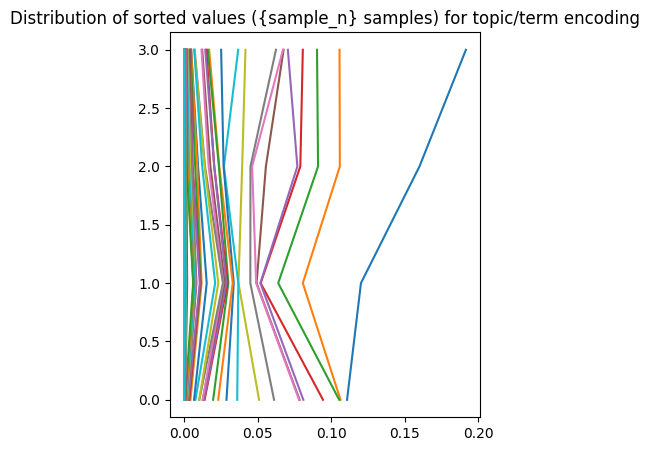

In [36]:
## term エンコード値の分布を確認

import matplotlib.pyplot as plt

plt.figure(figsize = (4,5))

sampling_rate = 0.3
df_size = len(topic_dist)
sample_n = round(df_size * sampling_rate)
topic_sampled = random.sample(list(topic_dist), sample_n)

T = sorted([ sorted(x, reverse = True) for x in topic_sampled ])

plt.plot(T, range(len(T)))
plt.title("Distribution of sorted values ({sample_n} samples) for topic/term encoding")
plt.show()

In [37]:
## tSNE を使った topics のグループ化 (3D)

from sklearn.manifold import TSNE
import numpy as np

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
## perplexity は結合の強さを表わす指数で，値に拠って結果が代わるので，色々な値を試すと良い

#perplexity_val = 10 # 大き過ぎると良くない
top_perplexity_reduct_rate = 0.3
perplexity_val = round(len(topic_dist) * top_perplexity_reduct_rate)
topic_tSNE_3d = TSNE(n_components = 3, random_state = 0, perplexity = perplexity_val, n_iter = 1000)

## データに適用
top_tSNE_3d_fitted = topic_tSNE_3d.fit_transform(np.array(topic_dist))

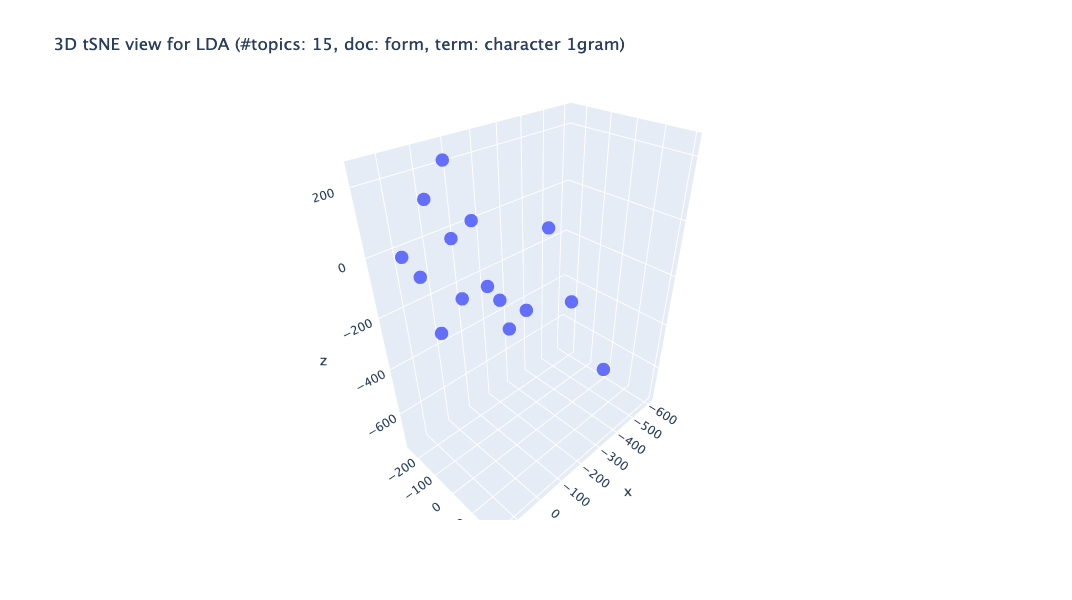

In [38]:
## Plotlyを使って tSNE の結果の可視化 (3D)

#import plotly.express as pex
import plotly.graph_objects as go
import numpy as np

top_tSNE = top_tSNE_3d_fitted
fig = go.Figure(data = [go.Scatter3d(x = top_tSNE[:,0], y = top_tSNE[:,1], z = top_tSNE[:,2],
                                     mode = 'markers')])

## 3D 散布図にラベルを追加する処理は未実装
title_val = f"3D tSNE view for LDA (#topics: {n_topics}, doc: {doc_type}, term: {term_size} {term_type})"
fig.update_layout(autosize = False,
                  width = 600, height = 600, title = title_val)
fig.show()

In [39]:
## 構築した LDA モデルを使って文(書)を分類する

## .get_document_topics(..) は　minimu_probability = 0としないと
## topic の値が小さい場合に値を返さないので，

## パラメター

ntopics = n_topics # LDA の構築の最に指定した値を使う

check      = False
encoding = [ ]
for i, row in df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc: {enc}")
    encoding.append(enc)
#
len(encoding)

5031

In [40]:
## enc 列の追加

#df['enc'] = np.array(encoding) # This flattens arrays
#df['enc'] = list(encoding) # ineffective
df['enc'] = [ list(map(lambda x: x[1], y)) for y in encoding ]
if verbose:
    df['enc']

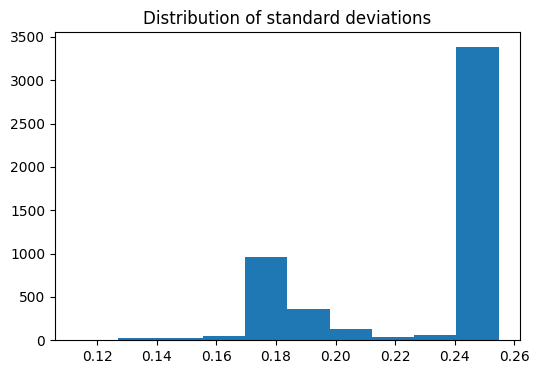

In [41]:
## エンコーディングのstd の分布を見る

from scipy.stats import tstd
from matplotlib import pyplot as plt

plt.figure(figsize = (6,4))

std_data = [ tstd(x) for x in df['enc'] ]
plt.hist(std_data)

plt.title("Distribution of standard deviations")
plt.show()

In [42]:
## doc のエンコーディング

## 一様分布の事例を除外

from scipy.stats import tstd # standard deviation の計算用

print(f"{len(df)} instances before filtering")

check = False

doc_enc = df['enc']
max_std = max([ tstd(x) for x in doc_enc])
if check: print(f"std max: {max_std}")

min_std = min([ tstd(x) for x in doc_enc])
if check: print(f"std min: {min_std}")

first_min_std = list(sorted(set([ tstd(x) for x in doc_enc])))[-0]
print(f"std 1st min: {first_min_std}")

second_min_std = list(sorted(set([ tstd(x) for x in doc_enc])))[-1]
print(f"std 2nd min: {second_min_std}")

5031 instances before filtering
std 1st min: 0.11291169306976362
std 2nd min: 0.25472535598622603


In [43]:
## df_filtered の定義

## 閾値は2番目に小さい値より小さく最小値よりは大きな値であるべき
std_threshold = second_min_std / 4 # 穏健な値を得るために4で割った
print(f"std_threshold: {std_threshold}")

## Rっぽい次のコードは通らない
#df_filtered = df[ df['encoding'] > std_threshold ]

## 通るのは次のコード: Creating a list of True/False and apply it to DataFrame 
std_tested = [ False if tstd(x) < std_threshold else True for x in df['enc'] ]
df_filtered = df[ std_tested ]
#
print(f"{len(df_filtered)} instances after filtering ({len(df) - len(df_filtered)} instances removed)")

std_threshold: 0.06368133899655651
5031 instances after filtering (0 instances removed)


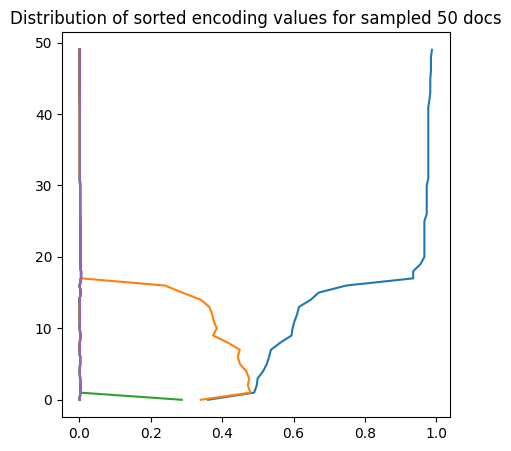

In [44]:
## doc エンコード値の分布を確認

sample_n = 50
E = sorted([ sorted(x, reverse = True) for x in df_filtered['enc'].sample(sample_n) ])

plt.figure(figsize = (5,5))
plt.plot(E, range(len(E)))
plt.title(f"Distribution of sorted encoding values for sampled {sample_n} docs")
plt.show()

In [45]:
len(df_filtered['language'])

5031

In [46]:
## tSNE 用の事例サンプリング = tSNE_df の定義

tSNE_sampling = True
tSNE_sampling_rate = 0.33
if tSNE_sampling:
    tSNE_df_original = df_filtered.copy()
    sample_n = round(len(tSNE_df_original) * tSNE_sampling_rate)
    tSNE_df = tSNE_df_original.sample(sample_n)
    print(f"tSNE_df has {len(tSNE_df)} rows after sampling")
else:
    tSNE_df = df_filtered

tSNE_df has 1660 rows after sampling


In [47]:
tSNE_df.columns

Index(['form', 'spell', 'sound', 'freq', 'english', 'esperanto', 'french',
       'german', 'icelandic', 'russian', 'swahili', 'size', 'language',
       '1gram', '2gram', '3gram', 'skippy2gram', 'skippy3gram', 'enc'],
      dtype='object')

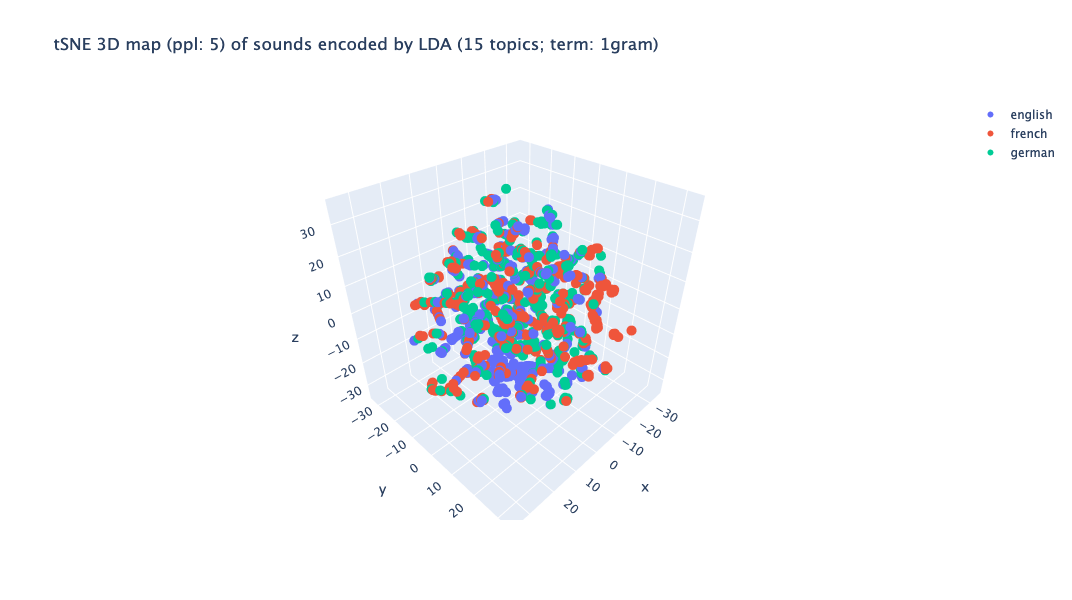

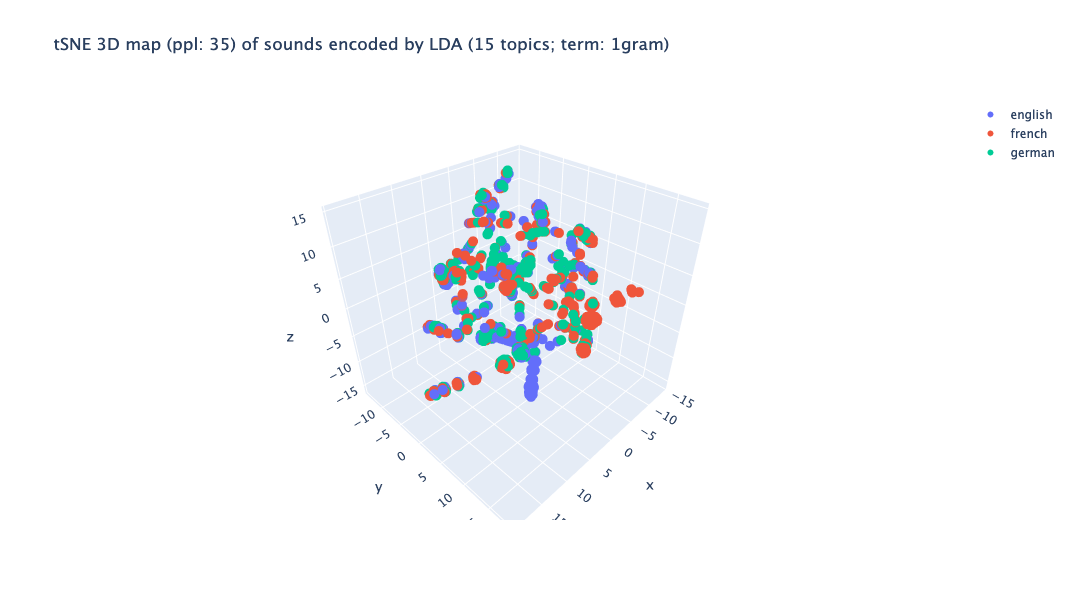

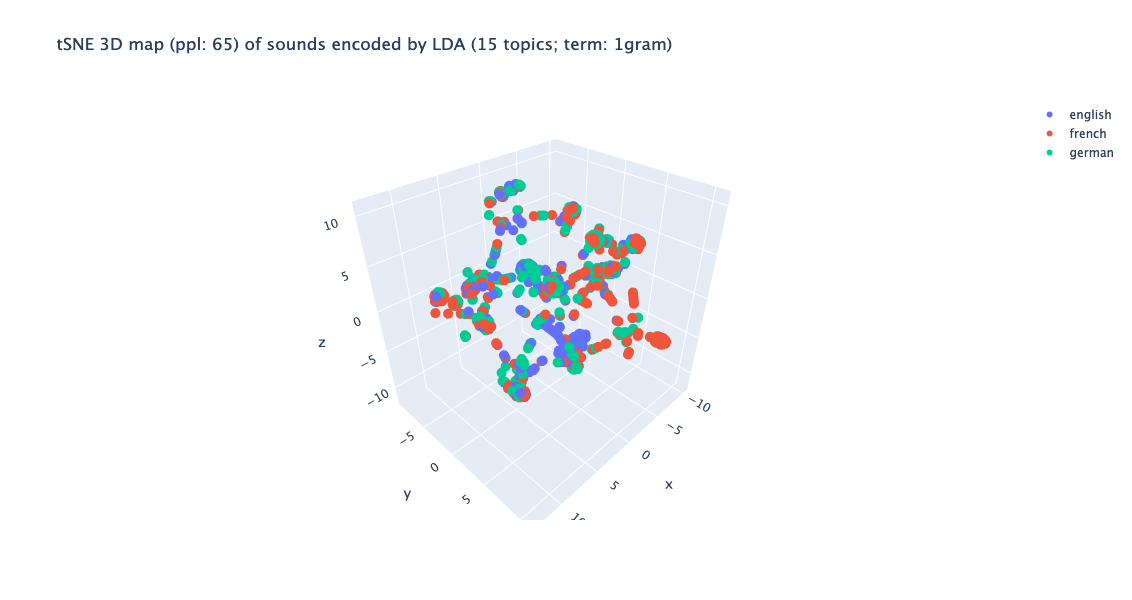

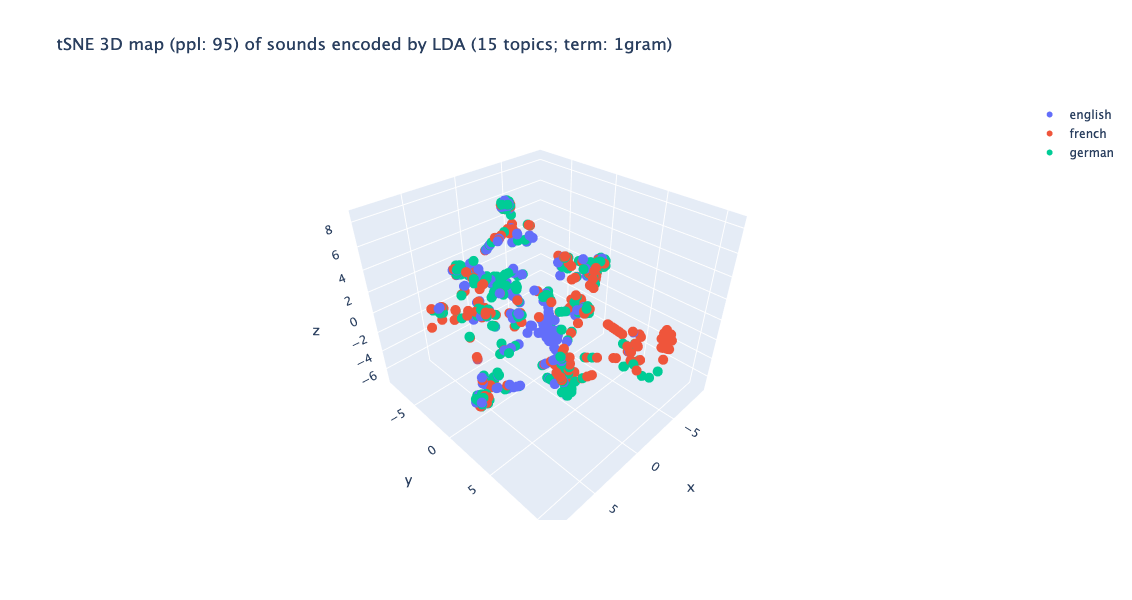

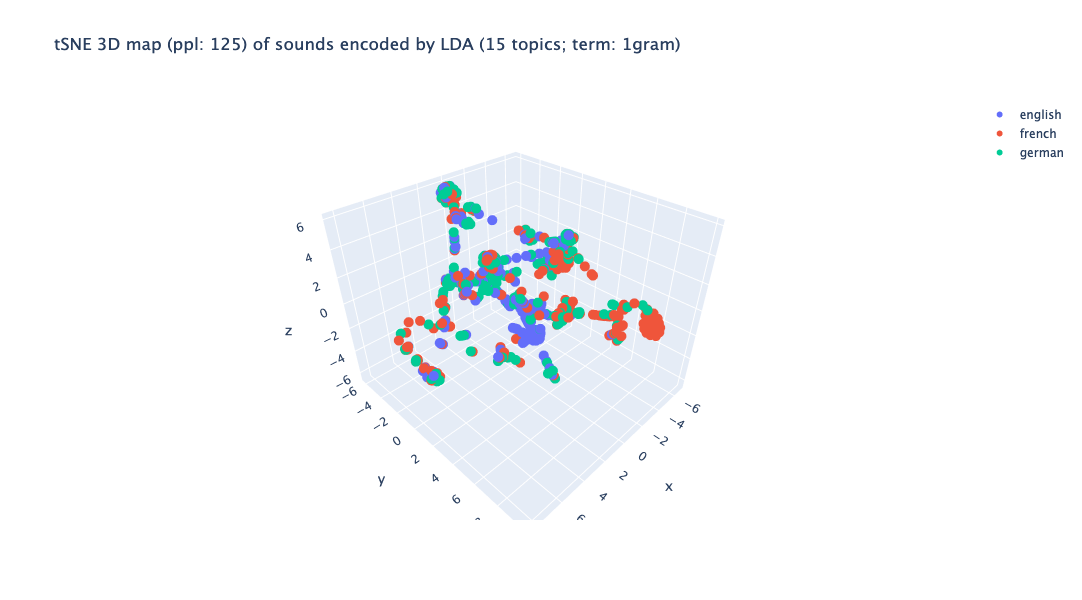

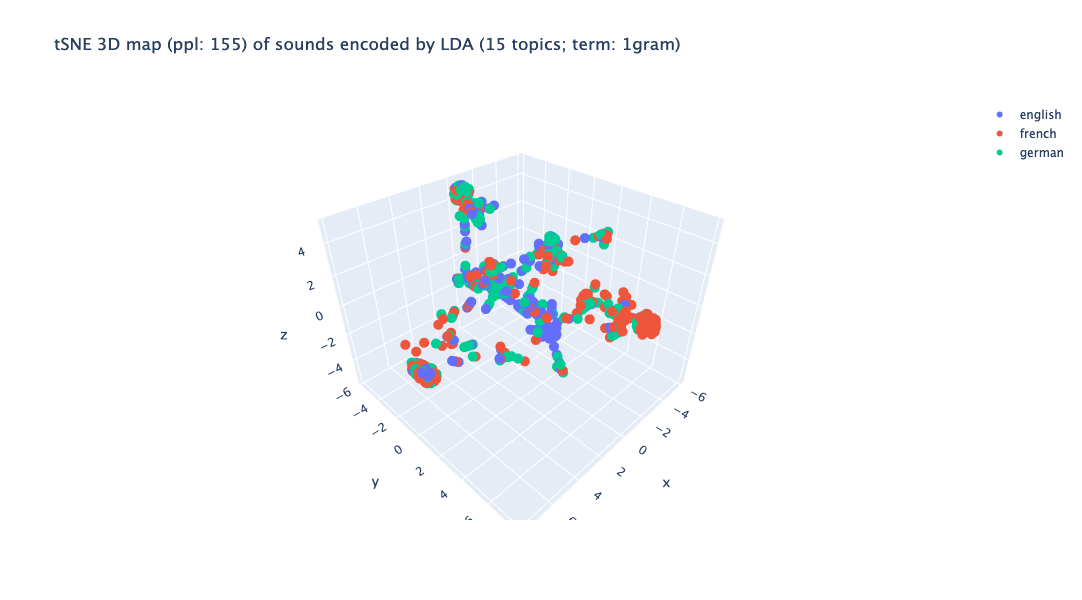

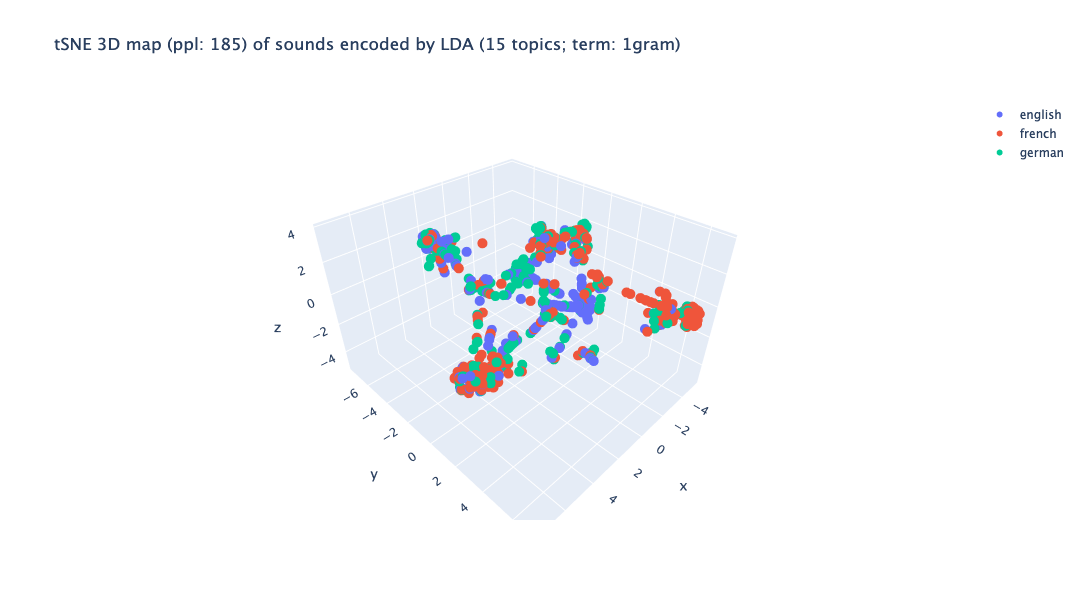

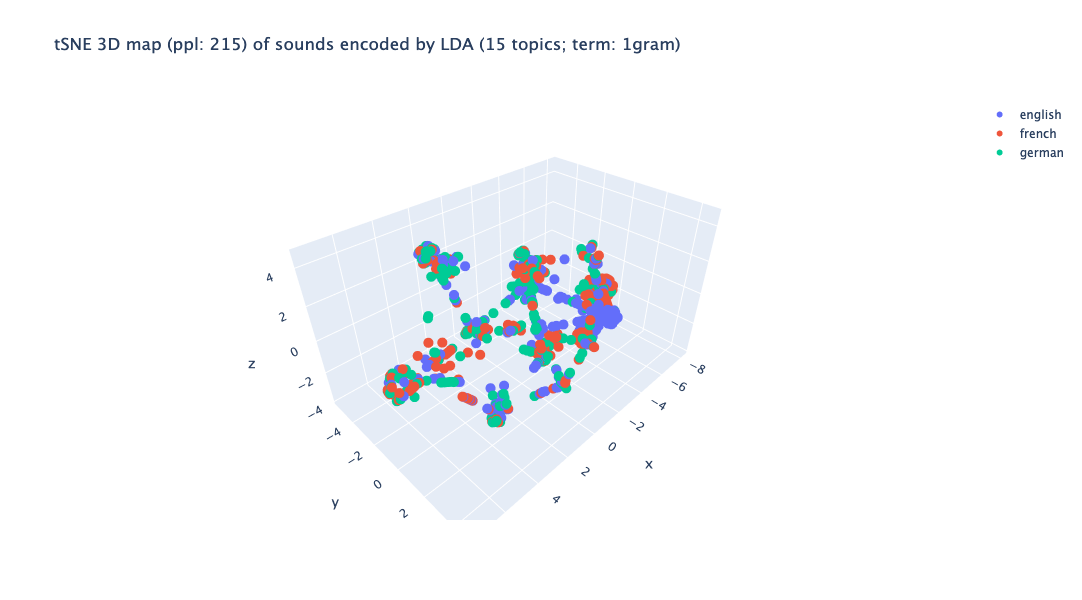

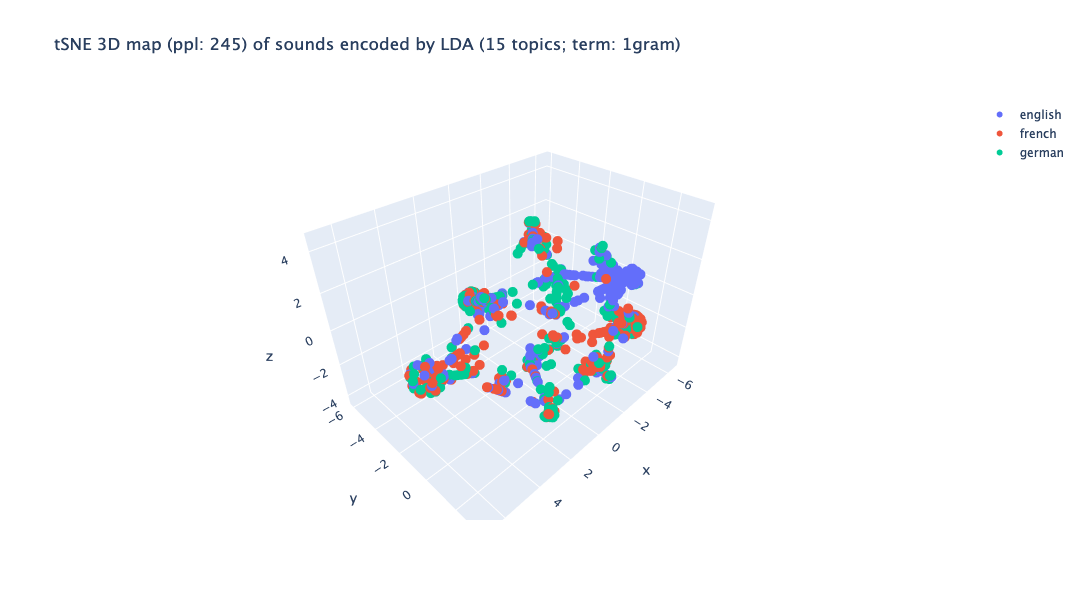

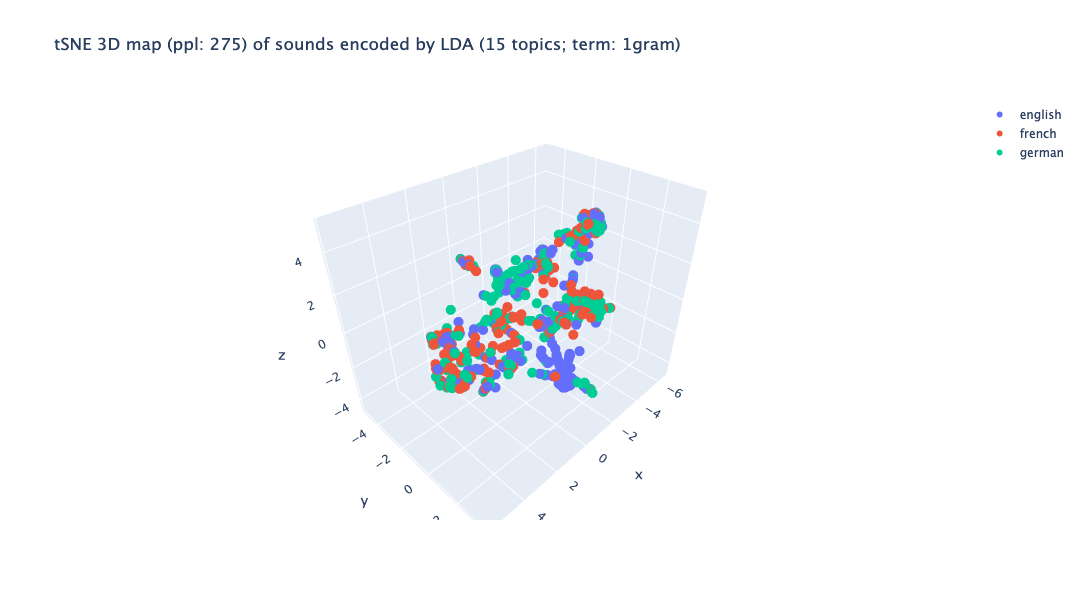

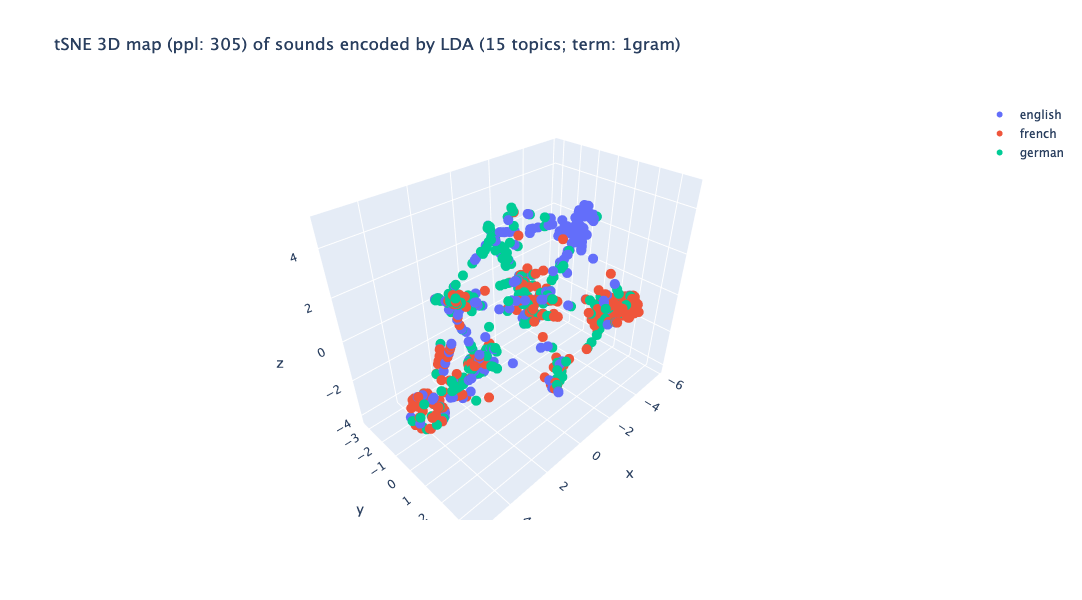

In [48]:
## tSNE の結果の可視化: Plotly を使った 3D 描画

import numpy as np
from sklearn.manifold import TSNE as tSNE

import plotly.express as pex
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## tSNE のパラメターを設定

perplexity_max_val = round(len(tSNE_df)/4)

for perplexity_val in range(5, perplexity_max_val, 30):
    
    ## tSNE 事例の生成
    tSNE_3d_varied = tSNE(n_components = 3, random_state = 0, perplexity = perplexity_val, n_iter = 1000)

    ## データに適用
    doc_enc = np.array(list(tSNE_df['enc']))
    doc_tSNE_3d_varied = tSNE_3d_varied.fit_transform(doc_enc)

    T = zip(doc_tSNE_3d_varied[:,0], doc_tSNE_3d_varied[:,1], doc_tSNE_3d_varied[:,2],
            tSNE_df['language']) # zip(..)が必要
    df = pd.DataFrame(T, columns = ['D1', 'D2', 'D3', 'language'])

    ## 作図
    fig = go.Figure()
    for lang in np.unique(df['language']):
        part = df[df['language'] == lang]
        fig.add_trace(
            go.Scatter3d(
                x = part['D1'], y = part['D2'], z = part['D3'],
                name = lang, mode = 'markers', marker = dict(size = 6),
                showlegend = True
            )
        )

    title_val = f"tSNE 3D map (ppl: {perplexity_val}) of {doc_attr}s encoded by LDA ({n_topics} topics; term: {term_type})"
    fig.update_layout(title = dict(text = title_val),
                      autosize = False, width = 600, height = 600,)
    fig.show()

In [49]:
## 階層クラスタリングのための事例のサンプリング

hc_sampling_rate = 0.1 # 大きくし過ぎると図が見にくい
df_size = len(tSNE_df)
hc_sample_n = round(df_size * hc_sampling_rate)
hc_df = tSNE_df.sample(hc_sample_n)
##
print(f"{hc_sample_n} rows are sampled")
hc_df['language'].value_counts()

166 rows are sampled


language
english    59
french     58
german     49
Name: count, dtype: int64

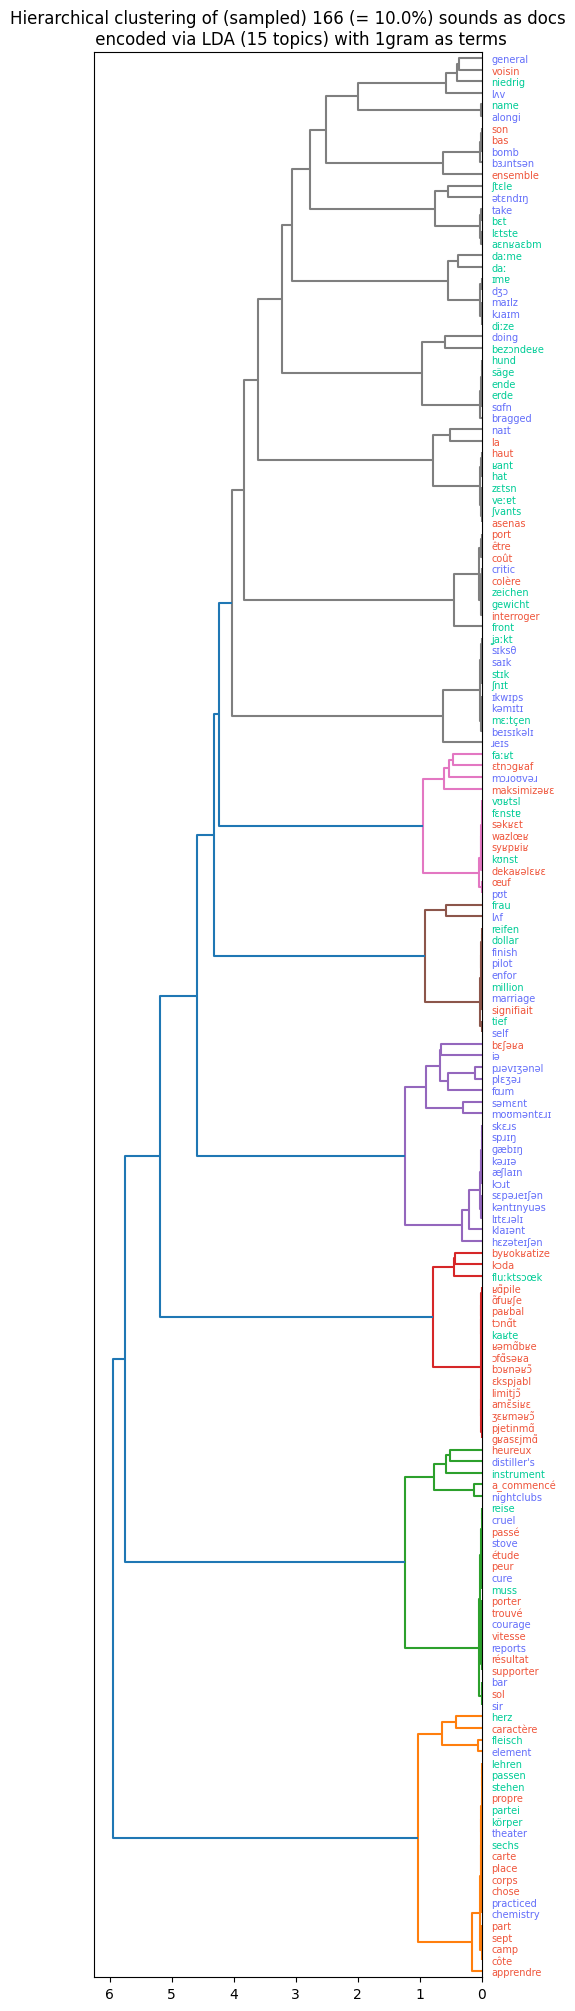

In [50]:
## doc 階層クラスタリングの実行

import numpy as np
import plotly
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage

## 距離行列の生成
Enc = list(hc_df['enc'])
linkage = linkage(Enc, method = 'ward', metric = 'euclidean')

## 描画サイズの指定
plt.figure(figsize = (5, round(len(hc_df) * 0.15))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_vals = [ x[:max_doc_size] for x in list(hc_df[doc_type]) ] # truncate doc keys

## 樹状分岐図の作成
dendrogram(linkage, orientation = 'left', labels = label_vals, leaf_font_size = 7)

## 描画
plt.title(f"Hierarchical clustering of (sampled) {len(hc_df)} (= {100 * hc_sampling_rate}%) {doc_attr}s as docs\n \
    encoded via LDA ({n_topics} topics) with {term_type} as terms")

## ラベルに language に対応する色を付ける
lang_colors = { lang_name : i for i, lang_name in enumerate(np.unique(hc_df['language'])) }
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    form = ticker.get_text()
    row = hc_df.loc[hc_df[doc_type] == form]
    #lang = row['language']
    lang = row['language'].to_string().split()[-1] # trick
    try:
        lang_id = lang_colors[lang]
    except (TypeError, KeyError):
        print(f"color encoding error at: {lang}")
    #
    ticker.set_color(plotly.colors.qualitative.Plotly[lang_id]) # id の基数調整
#
plt.show()

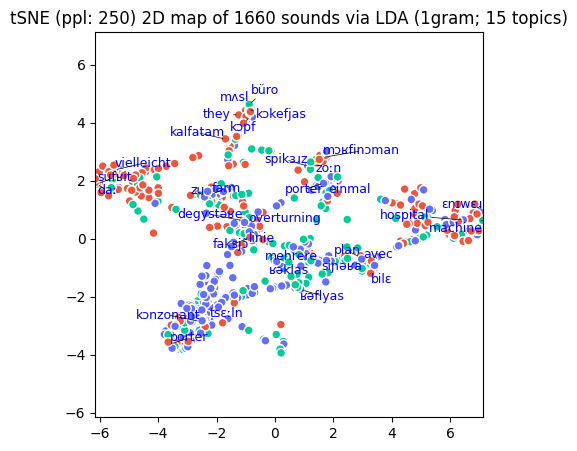

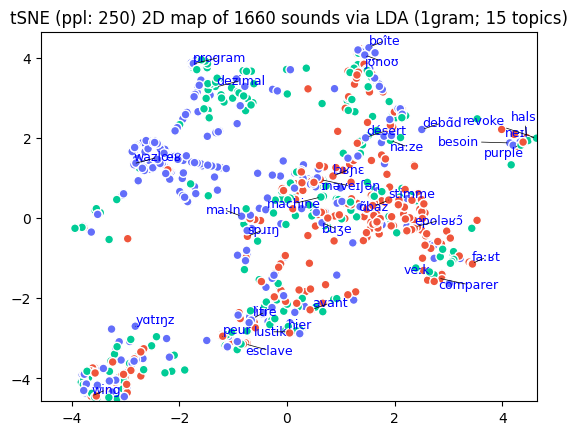

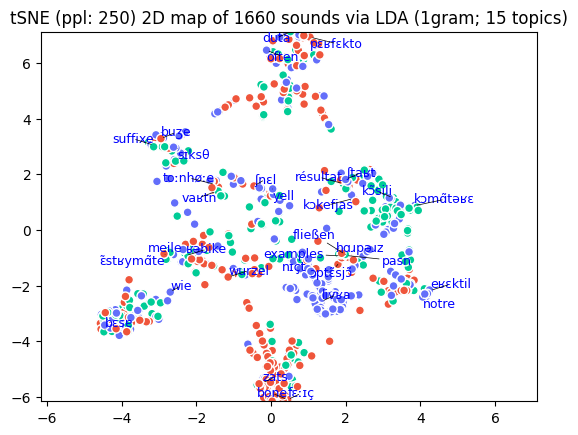

In [51]:
## tSNE の結果の可視化 (2D)

#import seaborn as sns
import numpy as np
import plotly
import plotly.express as pex
import matplotlib.pyplot as plt
from adjustText import adjust_text

## tSNE 事例の生成
perplexity_selected = 250
tSNE_3d = tSNE(n_components = 3, random_state = 0, perplexity = perplexity_selected, n_iter = 1000)

## データに適用
doc_enc = np.array(list(tSNE_df['enc']))
doc_tSNE_3d = tSNE_3d.fit_transform(doc_enc)

T = zip(doc_tSNE_3d[:,0], doc_tSNE_3d[:,1], doc_tSNE_3d[:,2],
        tSNE_df['language']) # zip(..)が必要
df = pd.DataFrame(T, columns = ['D1', 'D2', 'D3', 'language'])

## 描画
plt.figure(figsize = (5, 5))
plt.set_colors = pex.colors.qualitative.Plotly
    
for r in [ np.roll([0,1,2], -i) for i in range(0,3) ]:
    if check:
        print(r)
    X, Y = df.iloc[:,r[0]], df.iloc[:,r[1]]
    gmax = max(X.max(), Y.max())
    gmin = min(X.min(), Y.min())
    plt.xlim(gmin, gmax)
    plt.ylim(gmin, gmax)

    colormap = pex.colors.qualitative.Plotly
    lang_list = list(np.unique(tSNE_df['language']))
    cmapped = [ colormap[lang_list.index(lang)] for lang in df['language'] ]
    scatter = plt.scatter(X, Y, s = 40, c = cmapped, edgecolors = 'w')

    ## 文字を表示する事例のサンプリング
    lab_sampling_rate = 0.02
    lab_sample_n = round(len(tSNE_df) * lab_sampling_rate)
    sampled_keys = [ doc[:max_doc_size] for doc in random.sample(list(tSNE_df[doc_type]), lab_sample_n) ]

    ## labels の生成
    texts = [ ]
    for x, y, s in zip(X, Y, sampled_keys):
        texts.append(plt.text(x, y, s, size = 9, color = 'blue'))

    ## label に repel を追加: adjustText package の導入が必要
    adjust_text(texts, force_points = 0.2, force_text = 0.2,
                expand_points = (1, 1), expand_text = (1, 1),
                arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    #

    plt.title(f"tSNE (ppl: {perplexity_selected}) 2D map of {len(tSNE_df)} {doc_attr}s via LDA ({term_type}; {n_topics} topics)")
    #plt.legend(np.unique(cmapped))
    plt.show()